**Modelling Steps:**

    
    1. Loading the datasets 
    2. Data pre-processing
    3. Building the model
    4. Compiling the model
    5. Training the model
    6. Save the Model weights
    7. Using our model to make predictions on Test images
    8. Export the results to .csv file 
    

In [0]:
import pandas as pd 
import numpy as np 
import glob,pylab
!pip install pydicom
import pydicom
import os 
from zipfile import ZipFile
import csv
from tqdm import tqdm_notebook
import os
import cv2
from skimage import measure
from skimage.transform import 
import PIL # optional

import seaborn as sns
import warnings 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras
from keras.utils import to_categorical
from keras.models import Sequential, Input,Model
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import model_from_json
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [0]:
# Moutning the Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Defining the Project Path
Project_Path = '/content/drive/My Drive/Capstone/rsna-pneumonia-detection-challenge.zip'
train_path = '/content/stage_2_train_images/'
test_path = '/content/stage_2_test_images/'

In [0]:
#Extract Glove embedding zip file

with ZipFile(Project_Path, 'r') as z:
  z.extractall()

In [0]:
# reading the training data set with bounding box data 
df = pd.read_csv('/content/stage_2_train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
df.iloc[4]

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object

# New Section

In [0]:
# reading the sample dicom data to see the features available 
patientid = df['patientId'][0]
dcm_file = '/content/stage_2_train_images/%s.dcm' % patientid
dcm_data = pydicom.read_file(dcm_file)
dcm_data

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [0]:
im = dcm_data.pixel_array

[[144 128 114 ... 176 184 117]
 [125 109  95 ... 171 178 111]
 [104  89  75 ... 166 175 108]
 ...
 [ 16  14  11 ...  19  15   3]
 [ 18  16  12 ...  21  17   5]
 [ 19  17  13 ...  23  19   6]]


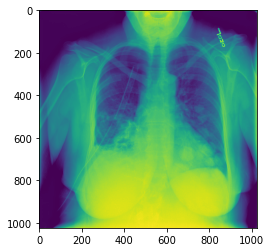

In [0]:
# sample image of one of the patient 
pylab.imshow(im)
print(im)

In [0]:
# Defining the function to parse and create a dictionary with all bounding box data at same point 

def parse_data(df):
    
    bounding_box = lambda row: [row['y'],row['x'],row['height'],row['width']]
    
    parsed = {}
    
    for n, row in df.iterrows():
        pid = row['patientId']
        
        if pid not in parsed:
            parsed[pid] = {
                'dicom':'stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []
            }
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(bounding_box(row))
    return parsed


In [0]:
parsed = parse_data(df)

In [0]:
parsed['00436515-870c-4b36-a041-de91049b9ab4']

{'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]],
 'dicom': 'stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
 'label': 1}

In [0]:
# Defining the function to draw bouding box over one of the patient dicom image 
def draw(data):
    
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array
    
    im = np.stack([im]*3,axis = 2)
    
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3)*256).astype('int')
        im = overlay_box(im=im,box=box,rgb = rgb,stroke =6)
    pylab.imshow(im)

def overlay_box(im,box,rgb,stroke=1):
    
    box = [int(b) for b in box]
    
    y1,x1,height,width = box
    y2 = y1+height
    x2 = x1+width
    
    im[y1:y1+stroke,x1:x2] = rgb
    im[y2:y2+stroke,x1:x2] = rgb
    im[y1:y2,x1:x1+stroke] = rgb
    im[y1:y2,x2:x2+stroke] = rgb
    
    return im

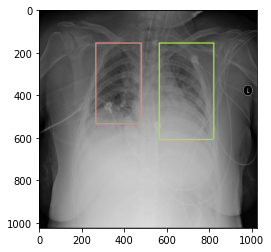

In [0]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

In [0]:
# Reading the labeled data 
df_labels = pd.read_csv('/content/stage_2_detailed_class_info.csv')

Total number of patients: 30227
total number of unique patients : 26684


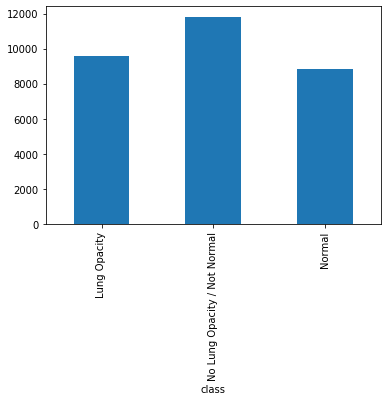

In [0]:
print('Total number of patients:', df_labels.shape[0])
print('total number of unique patients :', df_labels['patientId'].value_counts().shape[0])
df_labels.groupby('class').size().plot.bar()
#df_labels.sample(3)

Total number of patients: 30227
total number of unique patients : 26684


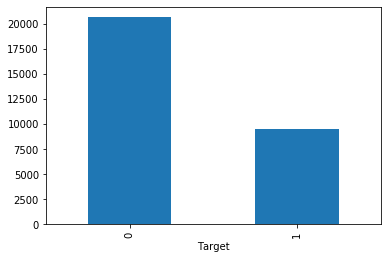

In [0]:
print('Total number of patients:', df.shape[0])
print('total number of unique patients :', df['patientId'].value_counts().shape[0])
df.groupby('Target').size().plot.bar()


In [0]:
summary = {}

for n, row in df_labels.iterrows():
    
    if row['class'] not in summary:
        summary[row['class']] = 0
        
    summary[row['class']] += 1
    
print(summary)

{'No Lung Opacity / Not Normal': 11821, 'Normal': 8851, 'Lung Opacity': 9555}


In [0]:
df_labels.isnull().sum()

patientId    0
class        0
dtype: int64

In [0]:
print(len(os.listdir('stage_2_train_images')))
print(len(os.listdir('stage_2_test_images')))


26684
3000


In [0]:
print(df['patientId'].nunique())

26684


In [0]:
df_labels.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [0]:
#del df_comb
assert df['patientId'].values.tolist() == df_labels['patientId'].values.tolist(), 'PatientId columns are different.'
df_comb = pd.concat([df,df_labels.drop('patientId',1)],1)
df_comb.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [0]:
tmp =df_comb.groupby(['patientId','Target','class'])['patientId'].count()
df1 = pd.DataFrame(data = {'Exams':tmp.values},index = tmp.index).reset_index()
tmp1 = df1.groupby(['Exams','Target','class']).count()
df2 = pd.DataFrame(data = tmp1.values,index = tmp1.index).reset_index()
df2.columns = ['Exams','Target','Class','Entries']
df2

,Exams,Target,Class,Entries
0,1,0,No Lung Opacity / Not Normal,11821
1,1,0,Normal,8851
2,1,1,Lung Opacity,2614
3,2,1,Lung Opacity,3266
4,3,1,Lung Opacity,119
5,4,1,Lung Opacity,13


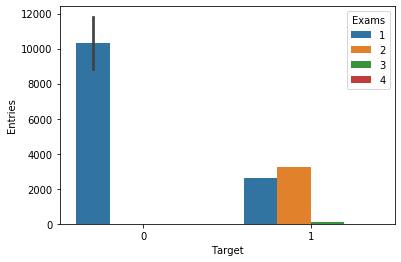

In [0]:

warnings.filterwarnings('ignore')

sns.barplot(x='Target',y = 'Entries',hue = 'Exams',data = df2)

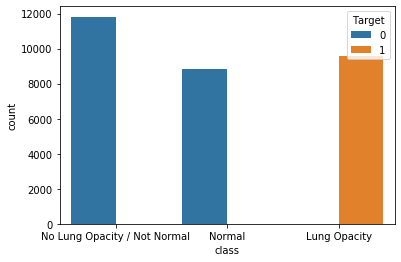

In [0]:
sns.countplot(x = 'class', hue = 'Target', data = df_comb);

In [0]:

vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition']
PATH = 'stage_2_train_images/'
def process_dicom_data(df_comb):
    for var in vars:
        df_comb[var] = None
    image_names = os.listdir(PATH)
    for i, img_name in tqdm_notebook(enumerate(image_names)):
        imagePath = os.path.join(PATH,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        
        idx = (df_comb['patientId']==data_row_img_data.PatientID)
        df_comb.loc[idx,'Modality'] = data_row_img_data.Modality
        df_comb.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        df_comb.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        df_comb.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        df_comb.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        

In [0]:
process_dicom_data(df_comb)

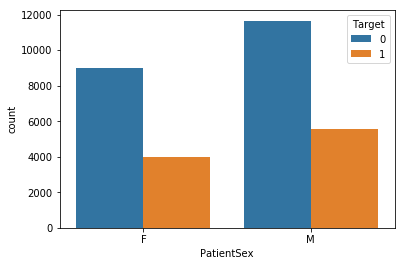

In [0]:
sns.countplot(x = 'PatientSex', hue = 'Target', data = df_comb);

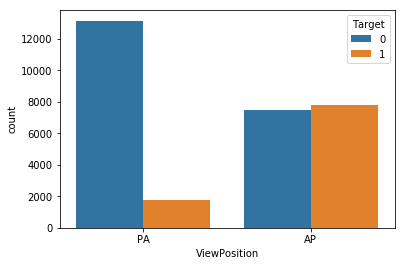

In [0]:
sns.countplot(x = 'ViewPosition', hue = 'Target', data = df_comb);

#AP - Anterior/Posterior;
#PA - Posterior/Anterior.

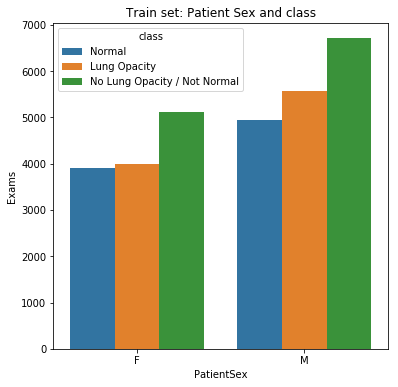

In [0]:
import matplotlib.pyplot as plt
tmp1 = df_comb.groupby(['class', 'PatientSex'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp1.values}, index=tmp1.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientSex']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()
fig, (ax) = plt.subplots(nrows=1,figsize=(6,6))
sns.barplot(ax=ax, x = 'PatientSex', y='Exams', hue='class',data=df3)
plt.title("Train set: Patient Sex and class")
plt.show()

In [0]:
# Converting the Training images from dicom foramt to jpeg format 

outdir = '/content/train_jpeg/'
#os.mkdir(outdir)

train_list = [ f for f in  os.listdir(train_path)]


for f in train_list:   # remove "[:10]" to convert all images 
    ds = pydicom.read_file(train_path + f) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir + f.replace('.dcm','.jpg'),img) # write png image

In [0]:
# Converting the Testing images from Dicom to Jpeg format 

outdir1 = '/content/test_jpeg/'
#os.mkdir(outdir)

test_list = [ f for f in  os.listdir(test_path)]


for f in test_list:   # remove "[:10]" to convert all images 
    ds = pydicom.read_file(test_path + f) # read dicom image
    img = ds.pixel_array # get image array
    cv2.imwrite(outdir1 + f.replace('.dcm','.jpg'),img) # write png image

In [0]:
len(os.listdir(outdir1))

3000

In [0]:
# Loading the training jpeg images and converting the size of 1024 , 1024 to 28 by 28 and dividing by 255 for normalization 
# Converting the list of images to array 

from tqdm import tqdm
from keras.preprocessing import image
path = '/content/'
train_images = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img(outdir+df['patientId'][i]+'.jpg', target_size=(28,28,1), grayscale=True)
    img = image.img_to_array(img)
    img = img/255
    train_images.append(img)
X = np.array(train_images)

  0%|          | 0/30227 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 30227/30227 [03:47<00:00, 133.16it/s]


In [0]:
# Loading the testing jpeg images and converting the size of 1024 , 1024 to 28 by 28 and dividing by 255 for normalization 
# Converting the list of images to array 

test_labels = pd.read_csv('/content/stage_2_sample_submission.csv')
test_images = []
for i in tqdm(range(test_labels.shape[0])):
    img = image.load_img(outdir1+test_labels['patientId'][i]+'.jpg', target_size=(28,28,1), grayscale=True)
    img = image.img_to_array(img)
    img = img/255
    test_images.append(img)
test = np.array(test_images)

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 3000/3000 [00:22<00:00, 132.61it/s]


In [0]:
# converting the target variable into categorical 

y=df['Target'].values
y = to_categorical(y)

In [0]:
# splitting the data set into training and validation 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.2)

In [0]:
# defining the batch size and epochs 
batch_size = 50
epochs = 10
num_classes=2

In [0]:
# creating the Baisc model CNN without any ealry stopping or other parameters 

model = Sequential()

model.add(Conv2D(32,kernel_size = (3,3),activation = 'linear',input_shape = (28,28,1),padding = 'same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2),padding = 'same'))

model.add(Conv2D(64,(3,3),activation = 'linear',padding = 'same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2),padding = 'same'))

model.add(Conv2D(128,(3,3),activation = 'linear',padding = 'same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2),padding = 'same'))

model.add(Conv2D(256,(3,3),activation = 'linear',padding = 'same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2),padding = 'same'))

model.add(Flatten())
model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))


In [0]:
# Compile model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


In [0]:
# Model training
train = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,
                  validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 24181 samples, validate on 6046 samples
Epoch 1/10
24181/24181 [==============================] - 50s 2ms/step - loss: 0.4797 - acc: 0.7713 - val_loss: 0.4632 - val_acc: 0.7789
Epoch 2/10
24181/24181 [==============================] - 50s 2ms/step - loss: 0.4470 - acc: 0.7901 - val_loss: 0.4446 - val_acc: 0.7904
Epoch 3/10
24181/24181 [==============================] - 49s 2ms/step - loss: 0.4362 - acc: 0.7960 - val_loss: 0.4369 - val_acc: 0.7934
Epoch 4/10
24181/24181 [==============================] - 51s 2ms/step - loss: 0.4246 - acc: 0.8012 - val_loss: 0.4307 - val_acc: 0.8017
Epoch 5/10
24181/24181 [==============================] - 50s 2ms/step - loss: 0.4174 - acc: 0.8031 - val_loss: 0.4318 - val_acc: 0.7959
Epoch 6/10
24181/24181 [==============================] - 50s 2ms/step - loss: 0.4028 - acc: 0.8114 - val_loss: 0.4285 - val_acc: 0.8004
Epoch 7/10
24181/24181 [==========

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 128)        

In [0]:
#Defining hyper parameters with model 2

batch_size = 64
epochs = 15
num_classes = 2

model_h1 = Sequential()
model_h1.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
model_h1.add(LeakyReLU(alpha=0.1))
model_h1.add(MaxPooling2D((2, 2),padding='same'))
model_h1.add(Dropout(0.25))
model_h1.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model_h1.add(LeakyReLU(alpha=0.1))
model_h1.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_h1.add(Dropout(0.25))
model_h1.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model_h1.add(LeakyReLU(alpha=0.1))                  
model_h1.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model_h1.add(Dropout(0.4))
model_h1.add(Flatten())
model_h1.add(Dense(128, activation='linear'))
model_h1.add(LeakyReLU(alpha=0.1))           
model_h1.add(Dropout(0.3))
model_h1.add(Dense(num_classes, activation='softmax'))

In [0]:

# compiling the model
model_h1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [0]:
# fitting the model
model_h1_fit = model_h1.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_valid, y_valid))

Train on 24181 samples, validate on 6046 samples
Epoch 1/15
24181/24181 [==============================] - 33s 1ms/step - loss: 0.5016 - acc: 0.7545 - val_loss: 0.4748 - val_acc: 0.7729
Epoch 2/15
24181/24181 [==============================] - 33s 1ms/step - loss: 0.4648 - acc: 0.7822 - val_loss: 0.4575 - val_acc: 0.7823
Epoch 3/15
24181/24181 [==============================] - 32s 1ms/step - loss: 0.4569 - acc: 0.7870 - val_loss: 0.4482 - val_acc: 0.7856
Epoch 4/15
24181/24181 [==============================] - 32s 1ms/step - loss: 0.4475 - acc: 0.7912 - val_loss: 0.4805 - val_acc: 0.7741
Epoch 5/15
24181/24181 [==============================] - 33s 1ms/step - loss: 0.4433 - acc: 0.7939 - val_loss: 0.4422 - val_acc: 0.7885
Epoch 6/15
24181/24181 [==============================] - 32s 1ms/step - loss: 0.4397 - acc: 0.7943 - val_loss: 0.4345 - val_acc: 0.7956
Epoch 7/15
24181/24181 [==============================] - 32s 1ms/step - loss: 0.4324 - acc: 0.7998 - val_loss: 0.4295 - val_acc:

In [0]:
# serialize model to JSON and save the weights

model_json = model_h1.to_json()
with open("model_h1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_h1.save_weights("model_h1.h5") #.pckl
print("Saved model to disk")

Saved model to disk


In [0]:
# load json and create model
json_file = open('/content/model_h1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# loading weights 
loaded_model.load_weights("/content/model_h1.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
# Prediciton on Test set
prediction = model_h1.predict_classes(test)

In [0]:
# Downloading the CSV file for the model Prediciton 
test_labels['label'] = prediction
test_labels.to_csv('prediction.csv',header=True,index=False)

In [0]:
# Creating a dictionary with Bounding box and patient id information 

pneumonia_bbox = {}

with open('/content/stage_2_train_labels.csv', mode='r') as infile:

    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
 
    for row in reader:
      fname = row[0]
      bbox = row[1:5]
      pneumonia = row[5]

      if pneumonia == '1':

        bbox = [int(float(i)) for i in bbox]

        if fname in pneumonia_bbox:

          pneumonia_bbox[fname].append(bbox)

        else:
          
          pneumonia_bbox[fname] = [bbox]

In [0]:
#splitting the training data to training and validation 

import os
import random
train_path = '/content/stage_2_train_images'
filenames = os.listdir(train_path)
random.shuffle(filenames)
size = 2000
val_size=500
train_images = filenames[:size]
val_images = filenames[size:val_size]

In [0]:
# Defining a class to generate the data for Keras model by reading dicom data 

class data_generator(keras.utils.Sequence):

  def __init__(self,path,filenames,pneumonia_bbox=None,batch_size=32,image_size=320,shuffle=True,augment=False,predict=False):

    self.path = path
    self.filenames = filenames
    self.pneumonia_bbox = pneumonia_bbox
    self.batch_size=batch_size
    self.image_size=image_size
    self.shuffle = shuffle
    self.augment = augment
    self.predict = predict
    self.on_epoch_end()
  
  def __load__(self,filename):
    img = pydicom.dcmread(os.path.join(self.path,filename)).pixel_array
    msk = np.zeros(img.shape)
    filename = filename.split('.')[0]

    if filename in pneumonia_bbox:
      for bbox in pneumonia_bbox[filename]:
        
        x, y, w, h = bbox
        # adding ones as the mask value where bbox is present for image
        msk[y:y+h,x:x+h] = 1

      # if augment then horizontal flit half the time
    if self.augment and random.random()>0.5:

      img = np.fliplr(img)
      msk = np.fliplr(msk)

      # resize both image and mask
    img = resize(img,(self.image_size,self.image_size),mode='reflect')
    msk = resize(msk,(self.image_size,self.image_size),mode = 'reflect') > 0.5
      # adding the channel dimension
    img = np.expand_dims(img,-1)
    msk = np.expand_dims(msk,-1)
    return img,msk

  def __loadpredict__(self,filename):
    img = pydicom.dcmread(os.path.join(self.path,filename)).pixel_array
    img = resize(img,(self.image_size,self.image_size),mode = 'reflect')
    img = np.expand_dims(img,-1)
    return img

  def __getitem__(self,index):
    # select batch of images
    filenames = self.filenames[index * self.batch_size:(index+1) * self.batch_size]
    # return images and filenames for predict mode
    if self.predict:
      imgs = [self.__loadpredict__(filename) for filename in filenames]
      imgs = np.array(imgs)
      return imgs,filenames
      # training mode , return images and masks 
    else:
      items = [self.__load__(filename) for filename in filenames]
      
      #unzip images and masks 
      imgs,msks = zip(*items)
      imgs = np.array(imgs)
      msks = np.array(msks)
      return imgs,msks

  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.filenames)

  def __len__(self):
    if self.predict:
      return int(np.ceil(len(self.filenames) / self.batch_size))  
    else:
      return int(len(self.filenames) / self.batch_size)

In [0]:
batch_size = 16
image_size = 320

In [0]:
# Performong Downsampling , Residual Block and up sampling 

def downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = downsample(channels, x)
        for b in range(n_blocks):
            x = resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(256, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2DTranspose(128, (8,8),strides=(4,4), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**(depth-2))(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
# define iou or jaccard loss function

def iou_loss(y_true,y_pred):
  y_true = tf.reshape(y_true,[-1])
  y_pred = tf.reshape(y_pred,[-1])

  iou = tf.reduce_sum(y_true * y_pred)
  score = (iou + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - iou + 1.)
  return 1-score

# combine cross entropy and iou loss
def iou_bce_loss(y_true,y_pred):
  return 0.5 * keras.losses.binary_crossentropy(y_true,y_pred) + 0.5 * iou_loss(y_true,y_pred)

def mean_iou(y_true,y_pred):
  y_pred = tf.round(y_pred)
  intersect = tf.reduce_sum(y_true * y_pred,axis = [1,2,3])
  union = tf.reduce_sum(y_true,axis=[1,2,3]) + tf.reduce_sum(y_pred,axis = [1,2,3])
  smooth = tf.ones(tf.shape(intersect))
  return tf.reduce_mean((intersect + smooth) / (union-intersect + smooth))

model = network(input_size=image_size,channels=32,n_blocks=2,depth=4)
model.compile(optimizer=keras.optimizers.Adam(),loss = iou_bce_loss,metrics=['accuracy',mean_iou])

# cosine learning rate annealing

def cosine_annealing(x):
  lr = 0.001
  epochs = 20
  return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

train_gen = data_generator(train_path,train_images,pneumonia_bbox,batch_size=batch_size,image_size=image_size,shuffle=True,
                           augment=True,predict=False)
valid_gen = data_generator(train_path,val_images,pneumonia_bbox,batch_size=batch_size,image_size=image_size,shuffle=True,
                           augment = True,predict = False)

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 320, 320, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 320, 320, 32) 128         conv2d_38[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_42 (LeakyReLU)      (None, 320, 320, 32) 0           batch_normalization_24[0][0]     
____________________________________________________________________________________________

In [0]:

history = model.fit_generator(train_gen, validation_data=valid_gen, epochs=3, shuffle=True)

Epoch 1/3
125/125 [==============================] - 3275s 26s/step - loss: 0.5635 - acc: 0.9505 - mean_iou: 0.6668
Epoch 2/3
125/125 [==============================] - 3216s 26s/step - loss: 0.5381 - acc: 0.9442 - mean_iou: 0.5673
Epoch 3/3
125/125 [==============================] - 3232s 26s/step - loss: 0.5226 - acc: 0.9435 - mean_iou: 0.5836


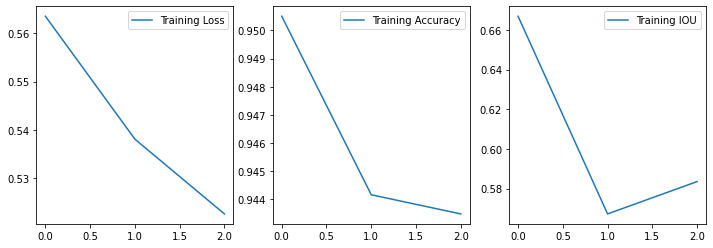

In [0]:
# Graphical Representation of Training loss 
plt.figure(figsize = (12,4))

plt.subplot(131)
plt.plot(history.epoch,history.history["loss"],label = "Training Loss")
plt.legend()

plt.subplot(132)
plt.plot(history.epoch,history.history["acc"],label = "Training Accuracy")
plt.legend()

plt.subplot(133)
plt.plot(history.epoch,history.history["mean_iou"],label = "Training IOU")
plt.legend()


In [0]:
history.history

{'acc': [0.9505023083686829, 0.9441606364250184, 0.9434799780845642],
 'loss': [0.5635299186706543, 0.5380816028118134, 0.5226160132884979],
 'mean_iou': [0.6668321264460683, 0.5672755205631256, 0.5835617179870606]}

In [0]:
# Listing Test Images and Reading and Preciting the Output Probability and Bounding Box 
test_images = '/content/stage_2_test_images'
test_files = os.listdir(test_images)
print('n test samples:', len(test_files))

# creating test data generator 
test_gen = data_generator(test_images, test_files, None, batch_size=20, image_size=image_size, shuffle=False, predict=True)

# create submission dictionary
sub_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    pred = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(pred, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        sub_dict[filename] = predictionString
    # stop if we've got them all
    if len(sub_dict) >= len(test_files):
        break
        
print("Done predicting...")
        
# save dictionary as csv file
sub = pd.DataFrame.from_dict(sub_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('test_prediction_submission.csv')

n test samples: 3000
Done predicting...


In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5") #.pckl
print("Saved model to disk")

Saved model to disk


In [0]:
# loading json and creating model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loading weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk
